# Filter method from https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b

In [1]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

In [2]:
static_features_dir = '/Users/gioelepozzi/Desktop/data/features_thesis/static_features.csv'
static_features_df = pd.read_csv(static_features_dir)

VA_mean_dir = '/Users/gioelepozzi/Desktop/data/annotations_thesis/static_annotations.csv'
VA_mean_df = pd.read_csv(VA_mean_dir)
V_mean_df = VA_mean_df[['music_ID','Valence(mean)']]

static_v_mean = pd.merge(static_features_df, V_mean_df, on=['music_ID'])

In [3]:
X = static_v_mean.drop(columns=['music_ID','Valence(mean)']) # feature matrix
y = static_v_mean['Valence(mean)'] # target variable

static_v_mean.head()

music_ID       tempo  total_beats  average_beats  chroma_stft_mean  \
0         1  129.199219        45448     688.606061          0.400506   
1         4  151.999081        39347     596.166667          0.524068   
2         5  135.999178       346030    1783.659794          0.541509   
3         6  143.554688        42339     622.632353          0.567836   
4         7  117.453835        31558     584.407407          0.390745   

   chroma_stft_std  chroma_stft_var  chroma_cq_mean  chroma_cq_std  \
0         0.298598         0.089161        0.401261       0.315778   
1         0.286910         0.082317        0.455447       0.293067   
2         0.290565         0.084428        0.398486       0.315170   
3         0.253213         0.064117        0.334812       0.302933   
4         0.305108         0.093091        0.584273       0.252345   

   chroma_cq_var  ...  skewMFCC[10]  meanMFCC[11]  stdMFCC[11]  \
0       0.099715  ...     -0.319755     13.889742    10.467580   
1       0.085889  ...     -0.542481      8.189248     9.720685   
2       0.099332  ...     -0.025306      3.352978    10.006372   
3       0.091768  ...     -0.280489      7.009110    10.573427   
4       0.063678  ...     -0.132205     -4.104206     9.502615   

   medianMFCC[11]  kurtMFCC[11]  skewMFCC[11]  mfcc_delta_mean  \
0       14.926630      0.093476     -0.417740         0.021779   
1        8.568237      0.684348     -0.305058         0.034024   
2        4.156285      0.240776     -0.381061         0.008901   
3        7.384045     -0.265838     -0.166282         0.000698   
4       -4.360930     -0.376099     -0.081237         0.020654   

   mfcc_delta_std  mfcc_delta_var  Valence(mean)  
0        4.934279       24.347107         0.5750  
1        5.334103       28.452656         0.2875  
2        5.894866       34.749443         0.2000  
3        5.513649       30.400322         0.3500  
4        3.540305       12.533757         0.7250  

[5 rows x 110 columns]

# Pearson Correlation

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

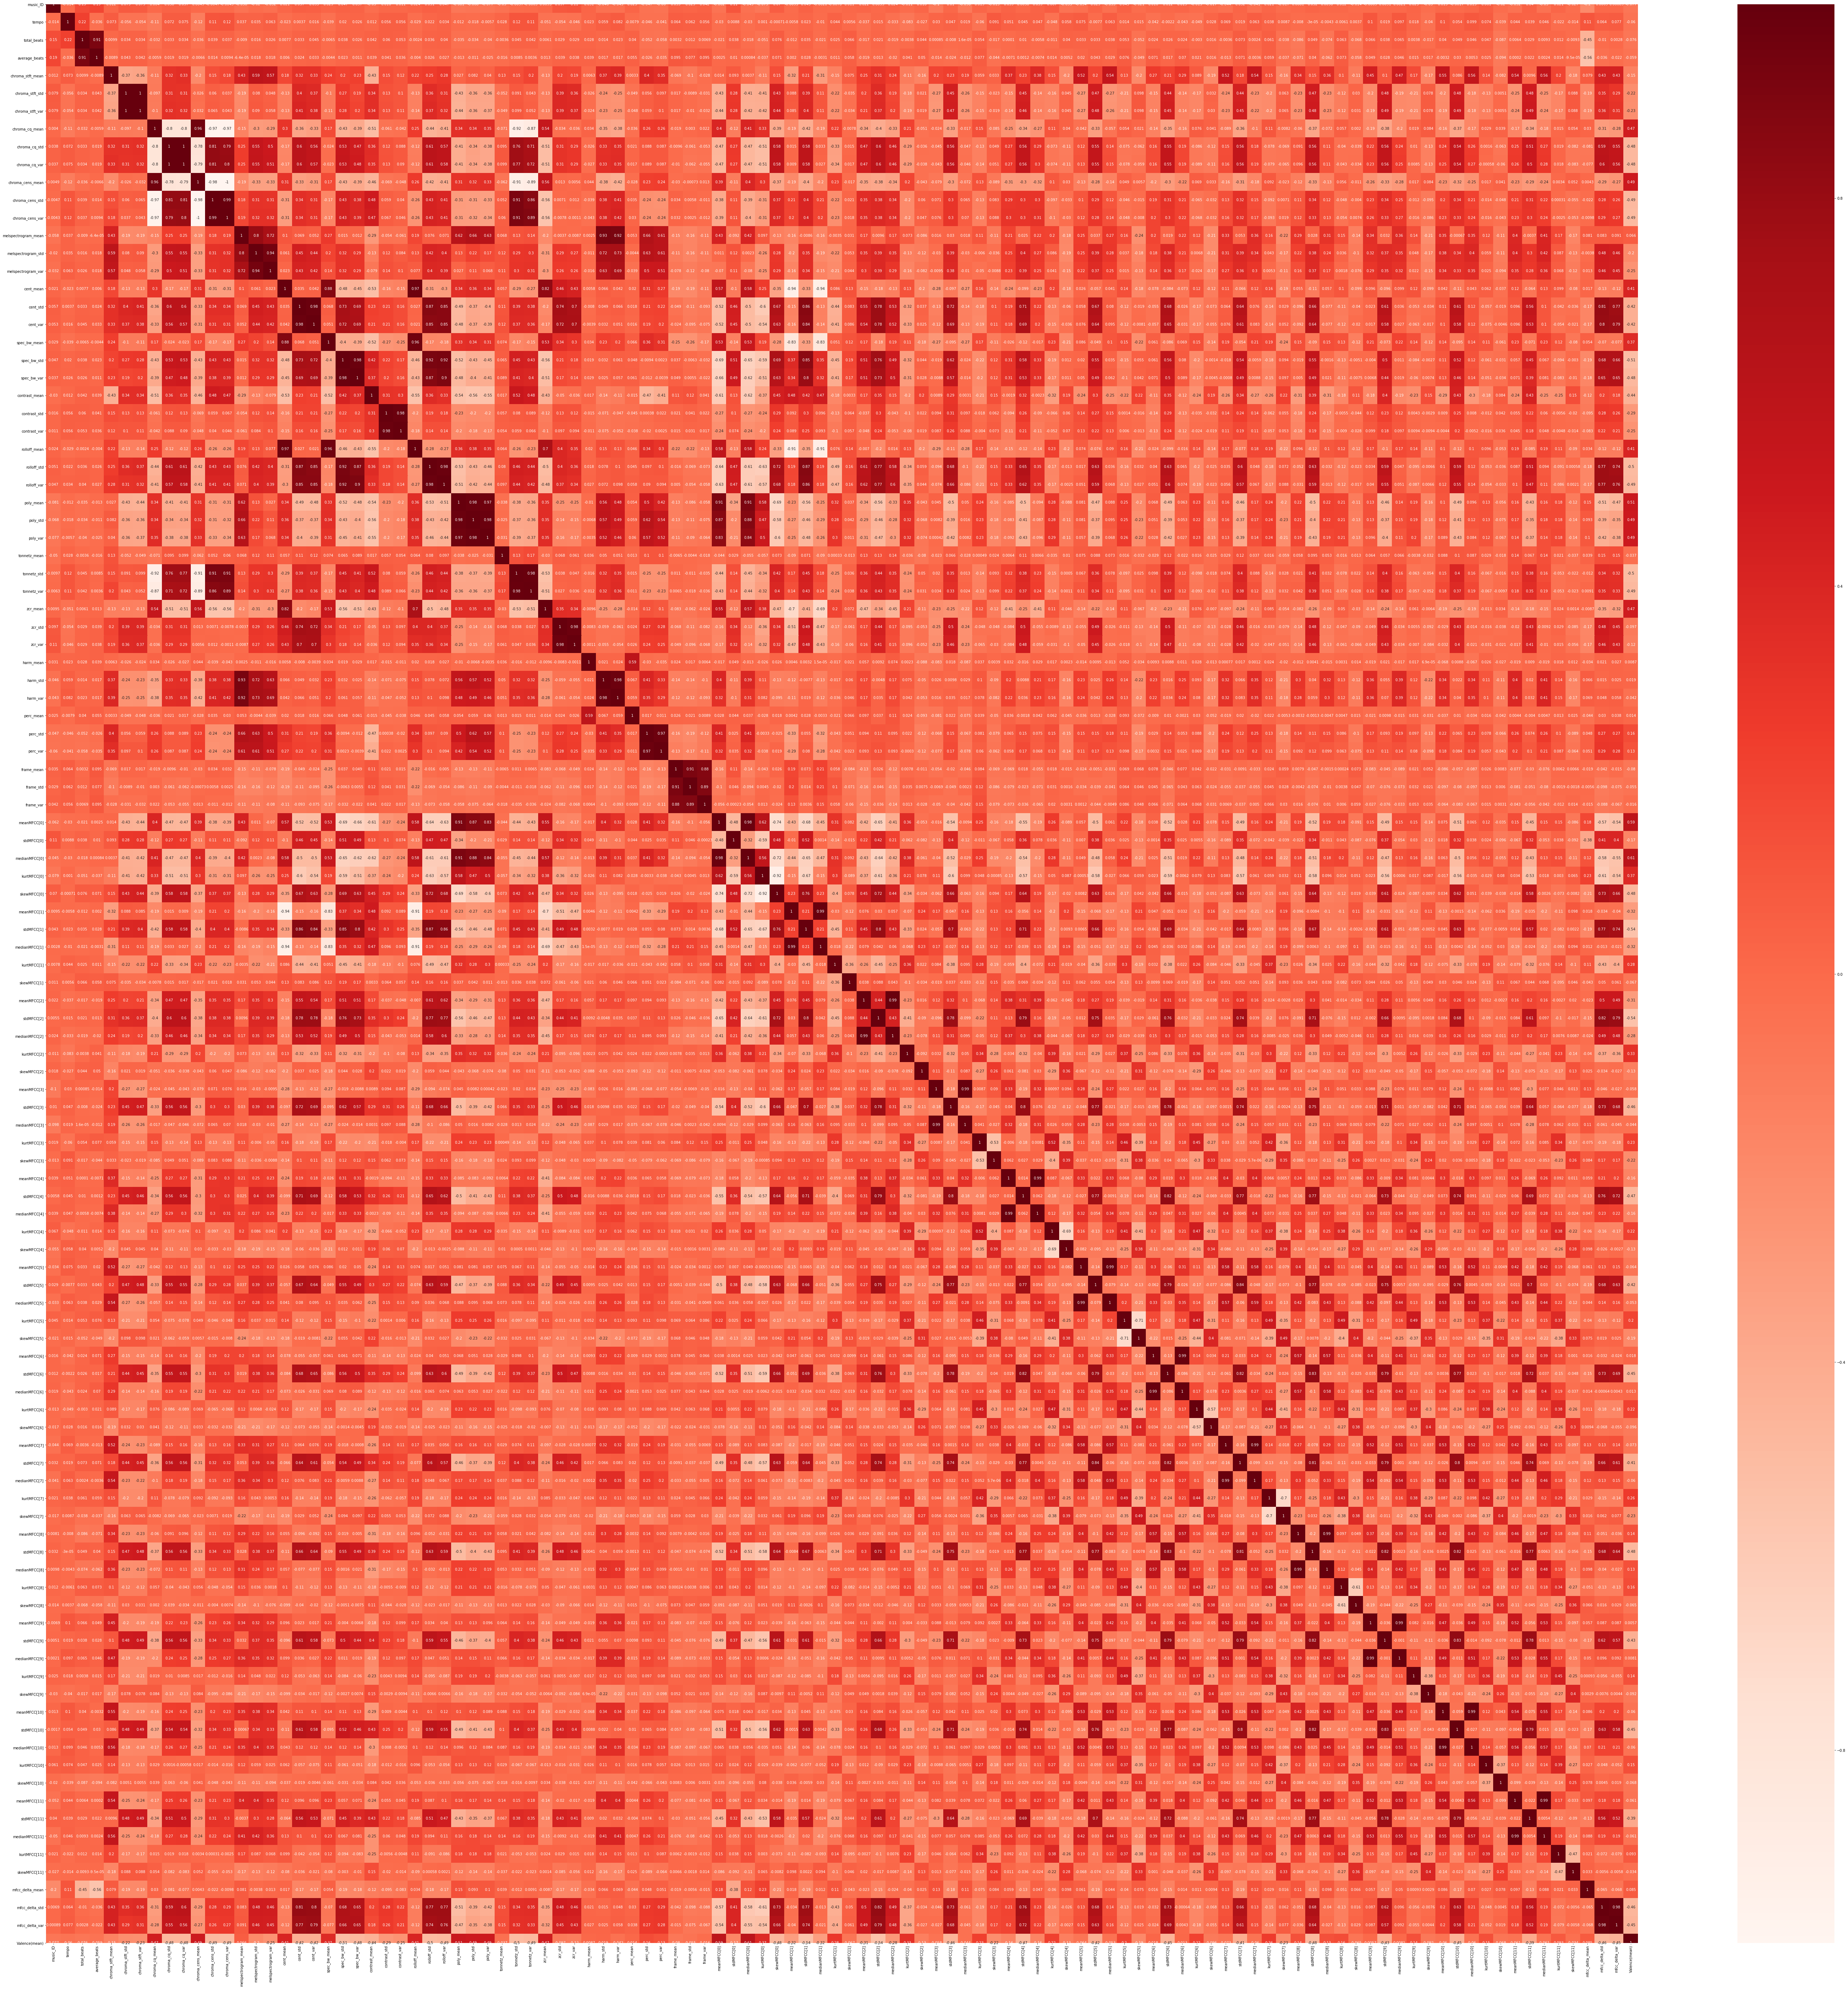

In [4]:
# The correlation coefficient has values between -1 to 1
# A value closer to 0 implies weaker correlation (exact 0 implying no correlation)
# A value closer to 1 implies stronger positive correlation
# A value closer to -1 implies stronger negative correlation

#static_v_mean = static_v_mean.drop(columns=['music_ID'])

plt.figure(figsize=(100,100))
cor = static_v_mean.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [5]:
#Correlation with output variable

cor_target = abs(cor['Valence(mean)'])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.5]
relevant_features

spec_bw_std      0.514848
poly_mean        0.512048
tonnetz_std      0.503954
meanMFCC[0]      0.593028
medianMFCC[0]    0.606916
stdMFCC[1]       0.541788
stdMFCC[2]       0.538732
Valence(mean)    1.000000
Name: Valence(mean), dtype: float64

In [6]:
pearson_list = relevant_features.axes
pearson_df = static_v_mean[np.intersect1d(static_v_mean.columns, pearson_list)]

pearson_df = pearson_df.drop(['Valence(mean)'], axis=1)

In [7]:
pearson_df.head()

meanMFCC[0]  medianMFCC[0]  poly_mean  spec_bw_std  stdMFCC[1]  stdMFCC[2]  \
0    -83.70189     -72.687010   1.911504   478.529036   42.897415   23.885254   
1   -125.98281    -121.689290   2.264582   649.558248   41.507088   29.238062   
2   -132.67284    -129.467040   1.980643   687.642264   50.807670   35.463287   
3    -92.41182     -60.998863   2.572290   625.793870   45.852420   34.386250   
4    -21.32030     -16.566483   3.317784   376.804763   30.141823   18.085280   

   tonnetz_std  
0     0.100549  
1     0.092003  
2     0.102440  
3     0.115761  
4     0.058003

# Backward elimination

In [8]:
# one iteration that found and remove the highest pvalue

#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)

#Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()
print(model.pvalues)

const               0.732476
tempo               0.601391
total_beats         0.628765
average_beats       0.910307
chroma_stft_mean    0.262580
                      ...   
kurtMFCC[11]        0.408957
skewMFCC[11]        0.376607
mfcc_delta_mean     0.466532
mfcc_delta_std      0.021468
mfcc_delta_var      0.024966
Length: 109, dtype: float64


/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return getattr(obj, method)(*args, **kwds)


In [9]:
#Backward Elimination
cols = list(X.columns)
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

['chroma_cq_mean', 'chroma_cq_std', 'chroma_cq_var', 'chroma_cens_mean', 'melspectrogram_mean', 'cent_mean', 'contrast_mean', 'contrast_std', 'tonnetz_std', 'tonnetz_var', 'harm_var', 'perc_std', 'frame_std', 'frame_var', 'meanMFCC[0]', 'stdMFCC[0]', 'skewMFCC[0]', 'medianMFCC[1]', 'skewMFCC[1]', 'meanMFCC[2]', 'medianMFCC[2]', 'stdMFCC[3]', 'medianMFCC[3]', 'skewMFCC[3]', 'kurtMFCC[4]', 'skewMFCC[4]', 'stdMFCC[5]', 'medianMFCC[5]', 'skewMFCC[5]', 'meanMFCC[7]', 'stdMFCC[8]', 'medianMFCC[8]', 'meanMFCC[9]', 'meanMFCC[11]', 'mfcc_delta_std', 'mfcc_delta_var']


In [10]:
backward_df = static_v_mean[np.intersect1d(static_v_mean.columns, selected_features_BE)]

In [11]:
backward_df.head()

cent_mean  chroma_cens_mean  chroma_cq_mean  chroma_cq_std  \
0  2874.357098          0.226653        0.401261       0.315778   
1  1754.980628          0.242035        0.455447       0.293067   
2  2209.346062          0.223880        0.398486       0.315170   
3  2511.312447          0.200098        0.334812       0.302933   
4  2713.926325          0.272532        0.584273       0.252345   

   chroma_cq_var  contrast_mean  contrast_std  frame_std  frame_var  harm_var  \
0       0.099715      21.357358      7.056910   1.363174   1.858242  0.017225   
1       0.085889      20.676389      7.409642   1.317973   1.737054  0.112057   
2       0.099332      20.725611      8.044129   0.919155   0.844845  0.072697   
3       0.091768      21.435182      7.932860   1.335567   1.783739  0.071636   
4       0.063678      20.252561      7.054508   1.500751   2.252254  0.031253   

   ...  skewMFCC[1]  skewMFCC[3]  skewMFCC[4]  skewMFCC[5]  stdMFCC[0]  \
0  ...     0.246240    -0.497022    -0.354608    -0.493410   70.369750   
1  ...    -0.333056    -0.361379    -0.196289    -0.818456   84.412970   
2  ...    -0.100528    -0.124900     0.026743    -0.324600   76.132590   
3  ...    -0.294355     0.756610    -0.178039    -0.243935  115.279520   
4  ...    -0.682530    -0.216047    -0.215887    -0.163493   56.604458   

   stdMFCC[3]  stdMFCC[5]  stdMFCC[8]  tonnetz_std  tonnetz_var  
0   18.221697   14.607980   13.788434     0.100549     0.010110  
1   23.422676   17.152494   14.236823     0.092003     0.008465  
2   20.977442   18.384447   14.336746     0.102440     0.010494  
3   27.453780   21.332376   13.315445     0.115761     0.013401  
4   15.859838   10.243058    8.761552     0.058003     0.003364  

[5 rows x 36 columns]

# Recursive Feature Elimination (RFE)

In [12]:
# RFE works by recursively removing attributes and building a model on those ones that remain
# accuracy metrics to rank. Gives the ranking of all the variables, 1 most important
# True as relevant feature, False for irrelevant features.

# here for a linear regression model with 7 features

model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 7)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)

#Fitting the data to model
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

[False False False False  True  True False  True  True False False  True
 False False False False False False False False False False False False
 False False False False False False False  True  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]
[ 90 101  92  12   1   1   9   1   1   4   5   1  51  88  98  86  94 100
  93  89  99  71  19  46  95  97 102  21  17  85  18   1   1   7  11   6
  10   3   2   8  14  15  69  64  65  84  83  91  82  67  77  87  73  57
  35  49  70  50  47  80  37  59  36  58  23  30  79  31  29  28  78  42
  75  53  20  44  96  45  61  60  54  81  55  56  

In [13]:
# now need to find the optimum number of features

#no of features
nof_list=np.arange(1,X.shape[1]) 
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 91
Score with 91 features: 0.507439


In [14]:
# get the features selected with RFE

cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, nof)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['chroma_stft_mean', 'chroma_stft_std', 'chroma_stft_var',
       'chroma_cq_mean', 'chroma_cq_std', 'chroma_cq_var', 'chroma_cens_mean',
       'chroma_cens_std', 'chroma_cens_var', 'melspectrogram_mean',
       'contrast_mean', 'contrast_std', 'contrast_var', 'poly_mean',
       'poly_std', 'poly_var', 'tonnetz_mean', 'tonnetz_std', 'tonnetz_var',
       'zcr_mean', 'zcr_std', 'zcr_var', 'harm_mean', 'harm_std', 'harm_var',
       'perc_mean', 'perc_std', 'perc_var', 'frame_mean', 'frame_std',
       'frame_var', 'meanMFCC[0]', 'stdMFCC[0]', 'kurtMFCC[0]', 'skewMFCC[0]',
       'meanMFCC[1]', 'medianMFCC[1]', 'kurtMFCC[1]', 'skewMFCC[1]',
       'meanMFCC[2]', 'stdMFCC[2]', 'medianMFCC[2]', 'kurtMFCC[2]',
       'skewMFCC[2]', 'meanMFCC[3]', 'stdMFCC[3]', 'medianMFCC[3]',
       'kurtMFCC[3]', 'skewMFCC[3]', 'meanMFCC[4]', 'stdMFCC[4]',
       'medianMFCC[4]', 'kurtMFCC[4]', 'skewMFCC[4]', 'meanMFCC[5]',
       'stdMFCC[5]', 'medianMFCC[5]', 'kurtMFCC[5]', 'skewMFCC[5]',
      

In [15]:
rfe_df = static_v_mean[np.intersect1d(static_v_mean.columns, selected_features_rfe)]

In [16]:
rfe_df.head()

chroma_cens_mean  chroma_cens_std  chroma_cens_var  chroma_cq_mean  \
0          0.226653         0.178778         0.031962        0.401261   
1          0.242035         0.157328         0.024752        0.455447   
2          0.223880         0.182240         0.033211        0.398486   
3          0.200098         0.208073         0.043294        0.334812   
4          0.272532         0.095182         0.009060        0.584273   

   chroma_cq_std  chroma_cq_var  chroma_stft_mean  chroma_stft_std  \
0       0.315778       0.099715          0.400506         0.298598   
1       0.293067       0.085889          0.524068         0.286910   
2       0.315170       0.099332          0.541509         0.290565   
3       0.302933       0.091768          0.567836         0.253213   
4       0.252345       0.063678          0.390745         0.305108   

   chroma_stft_var  contrast_mean  ...  stdMFCC[5]  stdMFCC[7]  stdMFCC[8]  \
0         0.089161      21.357358  ...   14.607980   14.800909   13.788434   
1         0.082317      20.676389  ...   17.152494   16.560871   14.236823   
2         0.084428      20.725611  ...   18.384447   14.145410   14.336746   
3         0.064117      21.435182  ...   21.332376   14.487218   13.315445   
4         0.093091      20.252561  ...   10.243058    9.647967    8.761552   

   stdMFCC[9]  tonnetz_mean  tonnetz_std  tonnetz_var  zcr_mean   zcr_std  \
0   13.535014      0.013284     0.100549     0.010110  0.130466  0.087886   
1   14.680905      0.013740     0.092003     0.008465  0.035259  0.040965   
2   11.252135     -0.007431     0.102440     0.010494  0.067432  0.080143   
3   11.575115      0.024854     0.115761     0.013401  0.087807  0.064541   
4   10.107035      0.008147     0.058003     0.003364  0.129173  0.091938   

    zcr_var  
0  0.007724  
1  0.001678  
2  0.006423  
3  0.004166  
4  0.008453  

[5 rows x 91 columns]

# Embedded method

In [17]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 135.692170
Best score using built-in LassoCV: 0.255399


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [18]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 5 variables and eliminated the other 103 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

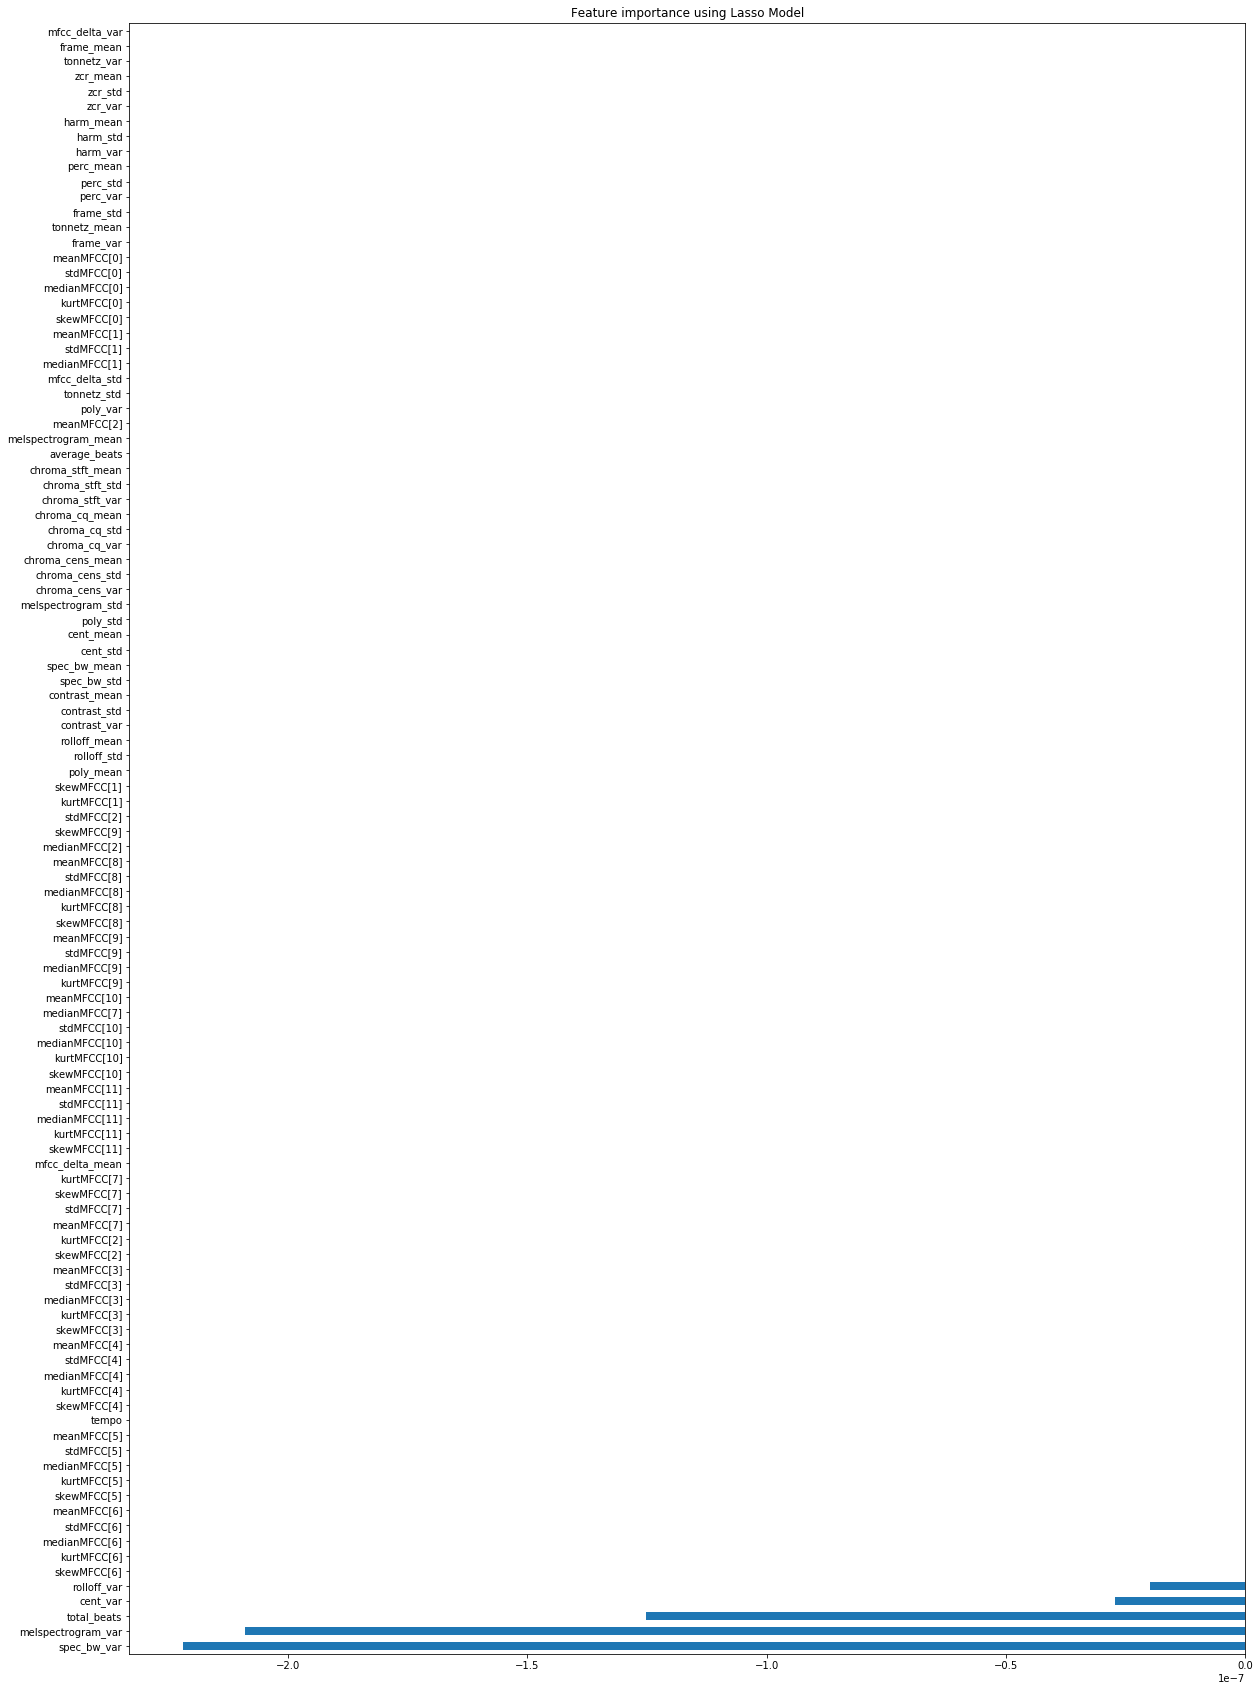

In [19]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 30)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [20]:
embedded_list = imp_coef[imp_coef!=0].axes

embedded_df = static_v_mean[np.intersect1d(static_v_mean.columns, embedded_list)]

In [21]:
embedded_df.head()

cent_var  melspectrogram_var   rolloff_var    spec_bw_var  total_beats
0  1.204583e+06           2759.4133  3.628859e+06  228990.037873        45448
1  8.856171e+05          98252.1200  5.142861e+06  421925.917122        39347
2  1.640503e+06          55598.0430  6.092386e+06  472851.883537       346030
3  1.249683e+06          25732.6800  4.911973e+06  391617.967738        42339
4  9.463196e+05          12443.5060  2.436096e+06  141981.829089        31558

# Function for feature selection

In [22]:
# target = 'Valence(mean)', 'Valence(std)', 'Arousal(mean)', 'Arousal(std)'
# selection_method = 'Pearson', 'backward', 'RFE', 'embedded'

def feature_sel(feature_dir, VA_dir, target, selection_method, *pearson_treshold):
    feature_df = pd.read_csv(feature_dir)
    VA_df = pd.read_csv(VA_dir)
    VA_df = VA_df[['music_ID',target]]
    df = pd.merge(feature_df, VA_df, on=['music_ID'])
    
    X = df.drop(columns=['music_ID',target]) # feature matrix
    y = df[target] # target variable
    
    if selection_method == 'Pearson':
        
        cor = df.corr()
        cor_target = abs(cor[target])
        relevant_features = cor_target[cor_target>pearson_treshold]
        pearson_list = relevant_features.axes
        pearson_df = df[np.intersect1d(df.columns, pearson_list)]
        pearson_df = pearson_df.drop([target], axis=1)
        
        print('Relevant features with Pearson method where correlation is greater than ', pearson_treshold, ':\n', relevant_features)
        return pearson_df
    
    if selection_method == 'backward':
        
        cols = list(X.columns)
        pmax = 1
        while (len(cols)>0):
            p = []
            X_1 = X[cols]
            X_1 = sm.add_constant(X_1)
            model = sm.OLS(y,X_1).fit()
            p = pd.Series(model.pvalues.values[1:],index = cols)      
            pmax = max(p)
            feature_with_p_max = p.idxmax()
            if(pmax>0.05):
                cols.remove(feature_with_p_max)
            else:
                break
        selected_features_BE = cols
        backward_df = df[np.intersect1d(df.columns, selected_features_BE)]
        
        print('Relevant features with backward method:\n',selected_features_BE)
        return backward_df
    
    if selection_method == 'RFE':
        
        nof_list=np.arange(1,X.shape[1]) 
        high_score=0
        nof=0           
        score_list =[]
        for n in range(len(nof_list)):
            X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
            model = LinearRegression()
            rfe = RFE(model,nof_list[n])
            X_train_rfe = rfe.fit_transform(X_train,y_train)
            X_test_rfe = rfe.transform(X_test)
            model.fit(X_train_rfe,y_train)
            score = model.score(X_test_rfe,y_test)
            score_list.append(score)
            if(score>high_score):
                high_score = score
                nof = nof_list[n]

        cols = list(X.columns)
        model = LinearRegression()
        #Initializing RFE model
        rfe = RFE(model, nof)             
        #Transforming data using RFE
        X_rfe = rfe.fit_transform(X,y)  
        #Fitting the data to model
        model.fit(X_rfe,y)              
        temp = pd.Series(rfe.support_,index = cols)
        selected_features_rfe = temp[temp==True].index        
        rfe_df = df[np.intersect1d(df.columns, selected_features_rfe)]
        
        print('Relevant features with RFE method:\n', selected_features_rfe)
        return rfe_df
    
    if selection_method == 'embedded':
        
        reg = LassoCV()
        reg.fit(X, y)
        coef = pd.Series(reg.coef_, index = X.columns)
        imp_coef = coef.sort_values()
        embedded_list = imp_coef[imp_coef!=0].axes
        embedded_df = df[np.intersect1d(df.columns, embedded_list)]
        
        print('Relevant featues with embedded method:\n', embedded_list)
        return embedded_df


In [30]:
static_features_dir = '/Users/gioelepozzi/Desktop/data/features_thesis/static_features.csv'
VA_mean_dir = '/Users/gioelepozzi/Desktop/data/annotations_thesis/static_annotations.csv'

feature_sel(static_features_dir, VA_mean_dir, 'Valence(mean)', 'Pearson', 0.5)

Relevant features with Pearson method where correlation is greater than  (0.5,) :
 spec_bw_std      0.514848
poly_mean        0.512048
tonnetz_std      0.503954
meanMFCC[0]      0.593028
medianMFCC[0]    0.606916
stdMFCC[1]       0.541788
stdMFCC[2]       0.538732
Valence(mean)    1.000000
Name: Valence(mean), dtype: float64


meanMFCC[0]  medianMFCC[0]  poly_mean  spec_bw_std  stdMFCC[1]  \
0     -83.701890     -72.687010   1.911504   478.529036   42.897415   
1    -125.982810    -121.689290   2.264582   649.558248   41.507088   
2    -132.672840    -129.467040   1.980643   687.642264   50.807670   
3     -92.411820     -60.998863   2.572290   625.793870   45.852420   
4     -21.320300     -16.566483   3.317784   376.804763   30.141823   
..           ...            ...        ...          ...         ...   
762   -41.476887     -33.215675   2.972650   457.454390   40.900130   
763    -2.120919      32.144768   3.529835   281.536797   22.851719   
764   -48.357372       7.986916   3.098459   325.666049   31.429749   
765   -49.374996      30.837170   3.515191   411.989762   19.514160   
766    11.099151      43.015180   3.955421   213.825505   18.393566   

     stdMFCC[2]  tonnetz_std  
0     23.885254     0.100549  
1     29.238062     0.092003  
2     35.463287     0.102440  
3     34.386250     0.115761  
4     18.085280     0.058003  
..          ...          ...  
762   20.678090     0.067828  
763   14.569227     0.061214  
764   18.852167     0.065145  
765   23.201437     0.049451  
766   13.271746     0.069946  

[767 rows x 7 columns]